<b><font size=20, color='#A020F0'>Class Notebook 7</font></b>

## Welcome to your seventh in-class jupyter notebook activity!
In this notebook you'll get more practice with xgcm

---

<b><font color='red'>Due Date: 18 November 2024 @ 9 am</font></b><br>

<b>How you will turn in this assignment</b><br> When you are ready to turn in your notebook, do the following:
1. Save your notebook and make sure your results are visible (cells have been executed)
2. Open a terminal and navigate to your local `aos573_completed_assignments` repository
3. Move your completed in-class notebook into your `Class_Notebooks` directory
4. `add` and `commit` your completed notebook
5. Finally, `push` your changes to your remote `aos573_completed_assignments` repository: `git push finished_work main` (you'll need to enter your username and personal access token)
6. <b><font color='red'>REMINDER: DO NOT TRACK OR PUSH THE DATA USED IN THE NOTEBOOK</font></b>

<b>Acknowledgements</b>: Parts of this notebook borrow heavily from examples on the [xgcm website](https://xgcm.readthedocs.io/en/latest/index.html)

---

## 1. More practice with xgcm Grid objects
In this section you'll create your own xgcm grid object and use it to compute the derivative of some data that you'll create below.

### 1.1 Create an xarray dataset with the following 1D fields:

1. $f_{1}(x_{i})=sin(x_{i})$
2. $f_{2}(x_{j})=cos(x_{j})$

Where $x_{i}\in[0,2\pi)$, $dx_{i}=\frac{\pi}{12}$, and $x_{j}=x_{i}-\frac{dx_{i}}{2}$

Make sure to add $x_{i}$ and $x_{j}$ as coordinates to your dataset.

In [3]:
import xgcm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dxi = (np.pi)/12
x_i = np.arange(0, 2*np.pi)
x_j = x_i - dxi/2
f1 = np.sin(x_i)
f2 = np.cos(x_j)

ds = xr.Dataset(data_vars={'f1': (('x_i'),f1), 'f2': (('x_j'),f2)},coords={'x_i': x_i, 'x_j': x_j})
ds

<xarray.Dataset>
Dimensions:  (x_i: 7, x_j: 7)
Coordinates:
  * x_i      (x_i) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0
  * x_j      (x_j) float64 -0.1309 0.8691 1.869 2.869 3.869 4.869 5.869
Data variables:
    f1       (x_i) float64 0.0 0.8415 0.9093 0.1411 -0.7568 -0.9589 -0.2794
    f2       (x_j) float64 0.9914 0.6455 -0.2939 -0.9631 -0.7468 0.1561 0.9155

### 1.2 Add a dx metric
Add a dx metric to your dataset that is defined at each $x_{i}$. Assume your data are periodic in x.

In [5]:
dxi2 = xr.DataArray(data=dxi*np.ones_like(x_i), coords=ds.x_i.coords)
ds['dxi'] = dxi2
ds

<xarray.Dataset>
Dimensions:  (x_i: 7, x_j: 7)
Coordinates:
  * x_i      (x_i) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0
  * x_j      (x_j) float64 -0.1309 0.8691 1.869 2.869 3.869 4.869 5.869
Data variables:
    f1       (x_i) float64 0.0 0.8415 0.9093 0.1411 -0.7568 -0.9589 -0.2794
    f2       (x_j) float64 0.9914 0.6455 -0.2939 -0.9631 -0.7468 0.1561 0.9155
    dxi      (x_i) float64 0.2618 0.2618 0.2618 0.2618 0.2618 0.2618 0.2618

### 1.3 Create an xgcm grid
Create an xgcm grid object that keeps track of the relationship between $x_{i}$ and $x_{j}$. Make sure to add your dx metric as well.

In [6]:
grid_metrics = {('x',): ['dxi']}
grid=xgcm.Grid(ds, coords={'x': {'center': 'x_i', 'left': 'x_j'}},periodic=['x'],metrics=grid_metrics)
grid

<xgcm.Grid>
x Axis (periodic, boundary=None):
  * center   x_i --> left
  * left     x_j --> center

### 1.4 Compute a derivative
Use the [derivative](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.derivative) function to compute $\frac{df_{1}}{dx}$. 

<b>_Before_</b> you try to do the derivative, which coordinate do you expect your result to have? Do you have all the appropriate grid information (i.e., the right metrics) to compute this particular derivative?

In [8]:
df1 = grid.derivative(ds.f1, axis='x')

_**After**_ you do the derivative: what do you think the warning in the output means?

### 1.5 Compute dx at $x_{j}$ points
If you keep getting this warning when you calculate the derivative, `UserWarning: Metric at ('xj',) being interpolated from metrics at dimensions ('xi',)"`, this is because your dx is defined at your $x_{i}$ points, but that's not exactly the dx that the derivative needs. We need dx defined on $x_{j}$ points instead (if this is confusing to you, it is time to draw a picture!). Thankfully, xgcm is generally smart enough to figure this out and just interpolate your grid $dx_{i}$ grid metric, which is why the computation above does not fail outright.

Regardless, go through the process of creating $dx_{j}$ by computing dx at $x_{j}$ points

><b><font color='green'>Hint:</font></b> Can you think of another xgcm grid operation that you can use that will allow you to compute dx at $x_{j}$ points? 

In [9]:
dxjdx_interp=grid.interp(ds.dxi,'x')
dxjdx_interp

<xarray.DataArray 'dxi' (x_j: 7)>
array([0.26179939, 0.26179939, 0.26179939, 0.26179939, 0.26179939,
       0.26179939, 0.26179939])
Coordinates:
  * x_j      (x_j) float64 -0.1309 0.8691 1.869 2.869 3.869 4.869 5.869

### 1.6 Take the derivative again
First, add your new dx at $x_{j}$ points ($dx_{j}$) to your dataset. Then recreate your xgcm grid from 1.3 but this time include your new metric.

Finally, compute $\frac{df_{1}}{dx}$, and check the coordinates that the result is on

In [10]:
ds['dxj'] = dxjdx_interp
grid_metrics2 = {('x',): ['dxj']}
grid2=xgcm.Grid(ds, coords={'x': {'center': 'x_i', 'left': 'x_j'}},periodic=['x'],metrics=grid_metrics)

df1 = grid.derivative(ds.f1, axis='x')

### 1.7 Plot your result
Make a line plot showing $\frac{df_{1}}{dx}$ and $f_{2}(x_{j})$. Do your results look how you would expect?

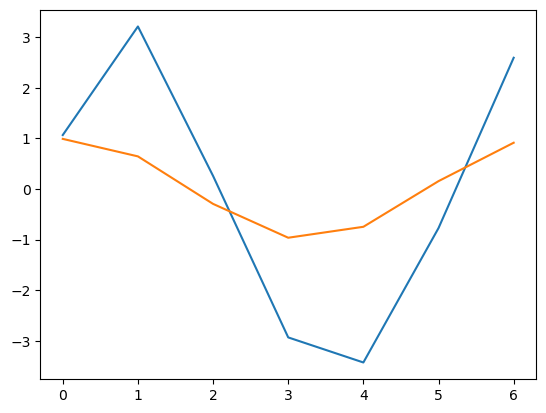

In [11]:
plt.plot(df1)
plt.plot(ds.f2)

---

## 2. Climate model output
In this section you'll be working with the CESM-LE output (`cesmLE.001.ocn.210012.nc`) we used in lecture on Monday. Go ahead and read in that data again (it's also in `/share/Notebook_data/`):

In [12]:
dsc = xr.open_dataset('~/share/Notebook_data/cesmLE.001.ocn.210012.nc')
dsc

<xarray.Dataset>
Dimensions:      (z_t: 60, yt: 384, xt: 320, yu: 384, xu: 320, z_w: 60,
                  z_w_top: 60, z_w_bot: 60)
Coordinates:
    time         object ...
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG        (yt, xt) float64 ...
    TLAT         (yt, xt) float64 ...
    ULONG        (yu, xu) float64 ...
    ULAT         (yu, xu) float64 ...
  * z_w          (z_w) float32 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_top      (z_w_top) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: yt, xt, yu, xu
Data variables: (12/15)
    TEMP         (z_t, yt, xt) float32 ...
    UVEL         (z_t, yu, xu) float32 ...
    VVEL         (z_t, yu, xu) float32 ...
    dz           (z_t) float32 ...
    DXT          (yt, xt) float64 ...
    DYT          (yt, xt) float64 ...
    ...           ...
    DYU          (yu, xu) float64 ...
    HTE          (yt, xu) float64 ...
    HTN          (yu, xt) float64 ...
    HUW          (yu, xt) float64 ...
    HUS          (yt, xu) float64 ...
    REGION_MASK  (yu, xu) float64 ...

### 2.1 Create an xgcm grid for the output
Recreate the xgcm grid we built for this dataset in class on Monday. Be sure to include the metrics. You can copy and paste the code from the lecture.

In [13]:
grid_metrics = {('x',): ['DXU', 'DXT','HTN','HUS'], # grid cell widths in x-direction
           ('y',): ['DYU', 'DYT','HTE','HUW'], # grid cell widths in y-direction
           ('z',): ['dz'], # grid cell width in z-direction     
           ('x', 'y'): ['UAREA', 'TAREA']} # Areas of velocity and tracer grid cells, respectively
grid=xgcm.Grid(dsc, coords={'x': {'center': 'xt', 'right': 'xu'},
                           'y':{'center':'yt','right':'yu'},
                           'z':{'center':'z_t','right':'z_w'}},periodic=['x'], metrics=grid_metrics)

grid

<xgcm.Grid>
x Axis (periodic, boundary=None):
  * center   xt --> right
  * right    xu --> center
y Axis (not periodic, boundary=None):
  * center   yt --> right
  * right    yu --> center
z Axis (not periodic, boundary=None):
  * center   z_t --> right
  * right    z_w --> center

### 2.2 Compute the barotropic streamfunction for the Pacific Ocean
The horizontal barotropic streamfunction $\psi$ is 

$\psi=\int_{x}\int_{z}vdzdx$

To compute $\psi$, you will need to integrate in z (the full depth of the ocean) and cumulatively integrate in x (the range of longitudes across the Pacific). Use the `REGION_MASK` variable in the dataset to pick out only the meridional velocity values in the Pacific Ocean before you integrate, otherwise you will end up doing a global cumulative integral, which isn't what we want.

You can use xgcm's [cumint()](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.cumint) function for the cumulative integral. 

How should you handle the non-periodic boundary in y (i.e., what boundary keyword do you think you should use in your integral)?

In [14]:
v_pac = dsc.VVEL.where(dsc.REGION_MASK==2)

In [15]:
int1 = grid.integrate(v_pac, 'z')
psi = grid.cumint(int1, 'x', boundary='fill')

### 2.3 Interpolate your result
Interpolate your streamfunction so that both x and y are located at the velocity points (xu, yu). Print the dimensions of $\psi$ beforehand to figure out how you need to interpolate your result.

In [31]:
print(psi.dims)
psi_interp=grid.interp(psi,'x')
psi_interp

('yu', 'xt')


<xarray.DataArray (yu: 384, xu: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Dimensions without coordinates: yu, xu

### 2.4 Plot the result
Make a quick 2D contour or pcolormesh plot of your interpolated psi to visualize your results. Before you do the plotting, you'll want to mask everything outside the Pacific again and add the land back in so it's easier to tell what you're looking at. I've set up the code to do so below. In my code snippet, `psi_interp` is the interpolated streamfunction from 2.3

In [33]:
#apply mask to the interpolated streamfunction from 2.3
psi_interp=psi_interp.where((dsc.REGION_MASK==2),other=0) #pick out only pacific values, set everything outside to zero
psi_interp=psi_interp.where(dsc.REGION_MASK!=0) #pick out everything but land

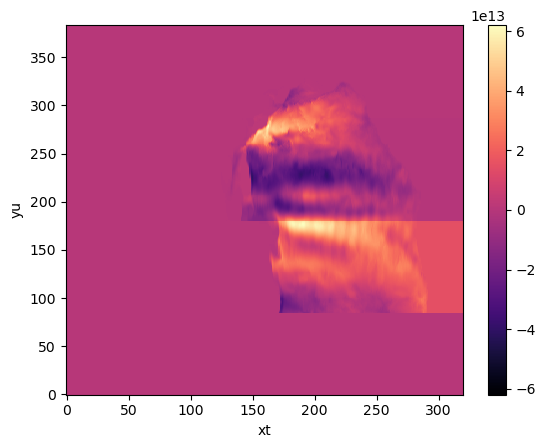

In [36]:
cmap=plt.cm.magma
psi.plot.pcolormesh(cmap=cmap)


---